In [1]:
%%capture
%pip install torch
%pip install torchvision
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install scipy

In [2]:
%pip install git+https://github.com/KellerJordan/Muon

  Cloning https://github.com/KellerJordan/Muon to /private/var/folders/jk/_xl3d2hs5x36rpykc1vsg8m40000gq/T/pip-req-build-suh_5mow
  Running command git clone --filter=blob:none --quiet https://github.com/KellerJordan/Muon /private/var/folders/jk/_xl3d2hs5x36rpykc1vsg8m40000gq/T/pip-req-build-suh_5mow
  Resolved https://github.com/KellerJordan/Muon to commit f90a42b28e00b8d9d2d05865fe90d9f39abcbcbd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [3]:
from mm import PINNMuonOptimizer

# Importing data

In [4]:

import pickle
from pathlib import Path
from typing import Callable, Dict, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output, display
import math
from gauss_newton import GaussNewtonPINNOptimizer, GaussNewtonStepResult

def _select_device() -> torch.device:
    if getattr(torch.backends, "mps", None) is not None and torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")


DEVICE = _select_device()
DEFAULT_DTYPE = torch.float32 if DEVICE.type == "mps" else torch.float64
torch.set_default_dtype(DEFAULT_DTYPE)
torch.manual_seed(42)

DATA_DIR = Path("data1d")
PRIMITIVE_LABELS = ["rho", "vx", "vy", "vz", "By", "Bz", "p"]
RAW_FIELD_KEYS = ["rho", "u1", "u2", "u3", "b2", "b3", "p"]


def load_snapshots(data_dir: Path = DATA_DIR) -> Dict[float, Dict[str, np.ndarray]]:
    snapshots: Dict[float, Dict[str, np.ndarray]] = {}
    for path in sorted(data_dir.glob("data1D_t_*.pkl")):
        with open(path, "rb") as fh:
            payload = pickle.load(fh)
        time_value = float(payload["time"])
        x_grid = np.asarray(payload["x"], dtype=np.float64)
        fields = payload["fields"]
        primitives = np.stack(
            [np.asarray(fields[key], dtype=np.float64) for key in RAW_FIELD_KEYS],
            axis=1,
        )
        snapshots[time_value] = {"x": x_grid, "primitives": primitives}
    if not snapshots:
        raise RuntimeError(f"No snapshot files found in {data_dir}")
    return snapshots


SNAPSHOTS = load_snapshots()
AVAILABLE_TIMES = np.array(sorted(SNAPSHOTS.keys()), dtype=np.float64)
X_DOMAIN: Tuple[float, float] = (
    SNAPSHOTS[AVAILABLE_TIMES[0]]["x"][0],
    SNAPSHOTS[AVAILABLE_TIMES[0]]["x"][-1],
)
T_DOMAIN: Tuple[float, float] = (AVAILABLE_TIMES[0], AVAILABLE_TIMES[-1])


def _resolve_time_key(t: Union[float, torch.Tensor, np.ndarray]) -> float:
    t_scalar = float(t.detach().cpu().item() if isinstance(t, torch.Tensor) else np.asarray(t).item())
    matches = np.isclose(AVAILABLE_TIMES, t_scalar, atol=1e-12)
    if not np.any(matches):
        raise ValueError(
            f"Requested time {t_scalar} not found. Available times: {AVAILABLE_TIMES.tolist()}"
        )
    return float(AVAILABLE_TIMES[matches][0])


def _prepare_query(x: Union[float, np.ndarray, torch.Tensor]) -> Tuple[np.ndarray, Tuple[int, ...]]:
    if isinstance(x, torch.Tensor):
        arr = x.detach().cpu().numpy()
    else:
        arr = np.asarray(x, dtype=np.float64)
    arr = np.atleast_1d(arr).astype(np.float64)
    original_shape = tuple(arr.shape)
    return arr.reshape(-1), original_shape


def cond(
    t: Union[float, torch.Tensor, np.ndarray],
    x: Union[float, np.ndarray, torch.Tensor],
    *,
    device: torch.device = None,
    as_tensor: bool = True,
) -> Union[np.ndarray, torch.Tensor]:
    time_key = _resolve_time_key(t)
    snapshot = SNAPSHOTS[time_key]
    x_query, original_shape = _prepare_query(x)
    x_clipped = np.clip(x_query, snapshot["x"][0], snapshot["x"][-1])
    interpolated = np.vstack(
        [
            np.interp(x_clipped, snapshot["x"], snapshot["primitives"][:, i])
            for i in range(snapshot["primitives"].shape[1])
        ]
    ).T
    if original_shape == ():
        reshaped = interpolated.reshape(snapshot["primitives"].shape[1],)
    else:
        target_shape = original_shape[:-1] if original_shape and original_shape[-1] == 1 else original_shape
        reshaped = interpolated.reshape(target_shape + (snapshot["primitives"].shape[1],))
    if not as_tensor:
        return reshaped
    target_device = device or DEVICE
    return torch.as_tensor(reshaped, device=target_device, dtype=torch.get_default_dtype())


def plot_reference_profiles(times=(0.0, 0.036, 0.1), num_points=512):
    x_grid = np.linspace(X_DOMAIN[0], X_DOMAIN[1], num_points)
    profiles = {t: cond(t, x_grid, as_tensor=False) for t in times}
    fig, axes = plt.subplots(len(PRIMITIVE_LABELS), 1, figsize=(8, 14), sharex=True)
    for axis_idx, (ax, label) in enumerate(zip(axes, PRIMITIVE_LABELS)):
        for t in times:
            ax.plot(x_grid, profiles[t][..., axis_idx], label=f"t={t:.3f}")
        ax.set_ylabel(label)
        ax.grid(True, alpha=0.3)
    axes[-1].set_xlabel("x")
    axes[0].legend(loc="upper right", fontsize="small", ncols=len(times))
    fig.suptitle("Reference primitive profiles from data")
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    return fig


# RMHD residual helpers

In [5]:
from RMHDEquations2D import primitives_to_conserved, flux_x

def _partial_derivative(outputs: torch.Tensor, coords: torch.Tensor, dim: int) -> torch.Tensor: 
    if outputs.ndim == 0:
        raise ValueError("outputs must have at least one dimension")

    outputs = outputs.reshape(-1, outputs.shape[-1])  # keeps (batch, components) no matter the input rank

    grads = []
    for component in range(outputs.shape[1]):
        grad = torch.autograd.grad(
            outputs[:, component].sum(),
            coords,
            create_graph=True,
            retain_graph=True,
        )[0]
        grads.append(grad[:, dim])
    return torch.stack(grads, dim=1)




def rmhd_residual(primitives: torch.Tensor, coords: torch.Tensor) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")
    
    B_x=5.0
    B_x_tensor = torch.full((primitives.shape[0], 1), B_x, device=primitives.device, dtype=primitives.dtype)
    primitives_2d = torch.cat([primitives[:, :4], B_x_tensor, primitives[:, 4:]], dim=1)
    mask1 = torch.tensor([0, 1, 2, 3, 5, 6, 7], device=primitives.device)
    conserved = primitives_to_conserved(primitives_2d,gamma=5/3)
    currents = flux_x(primitives_2d,gamma=5/3)
    conserved=conserved[:, mask1]
    currents=currents[:, mask1]
    dU_dt = _partial_derivative(conserved, coords, dim=1)
    dJ_dx = _partial_derivative(currents, coords, dim=0)
    return dU_dt +  dJ_dx



In [6]:
from jacobians import compute_M,compute_AX


def jacobian_residual(primitives: torch.Tensor, coords: torch.Tensor, B_x: float = 5.0) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")
    B_x=5.0
    B_x_tensor = torch.full((primitives.shape[0], 1), B_x, device=primitives.device, dtype=primitives.dtype)
    primitives_2d = torch.cat([primitives[:, :4], B_x_tensor, primitives[:, 4:]], dim=1)
    M = compute_M(primitives_2d)
    AX = compute_AX(primitives_2d)
    # Remove 4th row and 4th column (index 3) from M and AX
    mask1 = torch.tensor([0, 1, 2, 3, 5, 6, 7], device=M.device)
    #mask2 = torch.tensor([0, 1, 2, 4, 5, 6, 7], device=M.device)
    M = M[:, mask1, :][:, :, mask1]
    AX = AX[:, mask1, :][:, :, mask1]
    dP_dx = _partial_derivative(primitives, coords, dim=0).unsqueeze(-1)  # (batch, 7, 1)
    dP_dt = _partial_derivative(primitives, coords, dim=1).unsqueeze(-1)  # (batch, 7, 1)
    return (M @ dP_dt +  AX @ dP_dx).squeeze(-1)  # (batch, 7)



# Network 

In [7]:
class TrainableTanh(nn.Module):
    def __init__(self, init_gain=1.0, init_bias=0.0):
        super().__init__()
        self.log_gain = nn.Parameter(torch.tensor(float(np.log(init_gain))))
        self.bias = nn.Parameter(torch.tensor(init_bias))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gain = torch.exp(self.log_gain)  # keep gain positive
        return torch.tanh(gain * x + self.bias)

In [8]:
class PINN(nn.Module):
    def __init__(self, input_dim: int = 2, output_dim: int = 7, width: int = 16, depth: int = 12, activation=TrainableTanh):
        super().__init__()
        if depth < 1:
            raise ValueError("depth must be at least 1")
        self.activation = activation()
        layers = [nn.Linear(input_dim, width)]
        for _ in range(depth - 1):
            layers.append(nn.Linear(width, width))
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(width, output_dim)
        self.reset_parameters()

    def reset_parameters(self):
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.output_layer.weight)
        nn.init.zeros_(self.output_layer.bias)

    def forward(self, coords: torch.Tensor) -> torch.Tensor:
        x = coords
        for layer in self.layers:
            x = self.activation(layer(x))
        raw = self.output_layer(x)
        rho = torch.exp(raw[:, 0:1])
        velocities = torch.tanh(raw[:, 1:4])  # keep speeds subluminal
        by_bz = raw[:, 4:6]
        pressure = torch.exp(raw[:, 6:7])
        return torch.cat([rho, velocities, by_bz, pressure], dim=1)

# Training Loop

## samplers

In [9]:

from typing import Dict
from matplotlib.lines import Line2D

def sample_domain(n_points: int) -> torch.Tensor:
    x = torch.rand(n_points, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    t = torch.rand(n_points, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0]
    coords = torch.cat([x, t], dim=1)
    coords.requires_grad_(True)
    return coords


def prepare_boundary_points(n_points: int) -> torch.Tensor:
    n_left = n_points // 2
    n_right = n_points - n_left
    x_left = torch.full((n_left, 1), X_DOMAIN[0], device=DEVICE)
    x_right = torch.full((n_right, 1), X_DOMAIN[1], device=DEVICE)
    return torch.cat([x_left, x_right], dim=0)


def log_history(history: Dict[str, list], key: str, value: torch.Tensor, window_size: int = 10):
    history.setdefault(key, []).append(value.detach().item())
    if len(history[key]) >= window_size:
        rolling_avg = np.mean(history[key][-window_size:])
        history[key][-1] = rolling_avg


def normalize_batch(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    diff = targets
    rms = torch.sqrt(torch.mean(diff.pow(2), dim=0, keepdim=True))
    inv_scale = 1.0 / torch.clamp(rms, min=eps)
    return preds * inv_scale, targets * inv_scale, inv_scale


def update_running_inv_scale(residual: torch.Tensor, inv_scale: torch.Tensor | None, momentum: float = 0.9, eps: float = 1e-6) -> torch.Tensor:
    rms = torch.sqrt(torch.mean(residual.detach().pow(2), dim=0, keepdim=True))
    new_inv = 1.0 / torch.clamp(rms, min=eps)
    if inv_scale is None:
        return new_inv
    return momentum * inv_scale + (1.0 - momentum) * new_inv



## plotter

In [10]:
PLOT_LABELS= ['By']

def plot_training_progress(history: Dict[str, list], model: PINN, epoch: int, epochs: int):
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1.2])

    ax_loss = fig.add_subplot(gs[0, 0])
    for name, series in history.items():
        if not series:
            continue
        steps = np.arange(1, len(series) + 1)
        values = np.clip(np.asarray(series, dtype=np.float64), 1e-16, None)
        ax_loss.plot(steps, values, label=name)
    ax_loss.set_yscale('log')
    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss value')
    ax_loss.legend(fontsize='small', ncol=2)
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_title('Loss history')

    ax_heat = fig.add_subplot(gs[0, 1])
    x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 128, device=DEVICE)
    t_vis = torch.linspace(T_DOMAIN[0], T_DOMAIN[1], 128, device=DEVICE)
    X_mesh, T_mesh = torch.meshgrid(x_vis, t_vis, indexing='ij')
    coords_vis = torch.stack([X_mesh.reshape(-1), T_mesh.reshape(-1)], dim=1)
    with torch.no_grad():
        rho_vis = model(coords_vis).detach().cpu().numpy()[:, 0]
    rho_vis = rho_vis.reshape(x_vis.shape[0], t_vis.shape[0])
    pcm = ax_heat.pcolormesh(T_mesh.cpu().numpy(), X_mesh.cpu().numpy(), rho_vis, shading='auto', cmap='viridis')
    fig.colorbar(pcm, ax=ax_heat, label='rho')
    ax_heat.set_xlabel('t')
    ax_heat.set_ylabel('x')
    ax_heat.set_title('Density heatmap')







    ax_compare = fig.add_subplot(gs[1, :])
    x_plot = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
    coords_plot = torch.stack([x_plot, torch.full_like(x_plot, 0.036)], dim=1)
    with torch.no_grad():
        pinn_profiles = model(coords_plot).detach().cpu().numpy()
    reference_profiles = cond(0.036, x_plot.cpu().numpy(), as_tensor=False)

    entries = PLOT_LABELS or PRIMITIVE_LABELS
    resolved = []
    for entry in entries:
        if isinstance(entry, int):
            resolved.append((entry, PRIMITIVE_LABELS[entry]))
        else:
            idx = next(i for i, name in enumerate(PRIMITIVE_LABELS) if name.lower() == str(entry).lower())
            resolved.append((idx, PRIMITIVE_LABELS[idx]))

    x_np = x_plot.cpu().numpy()
    colors = plt.cm.tab10(np.linspace(0, 1, len(resolved)))
    for color, (idx, label) in zip(colors, resolved):
        ax_compare.plot(x_np, pinn_profiles[:, idx], color=color, linestyle='-', linewidth=1.2)
        ax_compare.plot(x_np, reference_profiles[:, idx], color=color, linestyle='--', linewidth=1.0)

    handles = [Line2D([0], [0], color=color) for color in colors]
    ax_compare.legend(handles, [label for _, label in resolved], title='Primitive', loc='upper right', fontsize='small')
    ax_compare.legend(handles=[
        Line2D([0], [0], color='black', linestyle='-', label='PINN'),
        Line2D([0], [0], color='black', linestyle='--', label='Data'),
    ], loc='lower right', fontsize='small')
    ax_compare.set_xlabel('x')
    ax_compare.set_title('t = 0.036 comparison')
    ax_compare.grid(True, alpha=0.3)






    fig.suptitle(f'Epoch {epoch}/{epochs}')
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    display(fig)
    plt.close(fig)


## Muon ptimizer


In [11]:
import torch
from torch.optim.optimizer import Optimizer

class ScaledMuon(Optimizer):
  
    def __init__(self, param_groups):
        # param_groups is a list of dicts as usual in PyTorch
        super().__init__(param_groups, {})

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            lr = group.get("lr", 1e-3)
            alpha = group.get("momentum", 0.9)
            role = group.get("role", "hidden")

            for p in group["params"]:
                if p.grad is None:
                    continue

                g = p.grad

                # momentum buffer M^t
                state = self.state.setdefault(p, {})
                if "momentum_buf" not in state:
                    state["momentum_buf"] = torch.zeros_like(p)
                m = state["momentum_buf"]

                # M^t = α M^{t-1} + (1-α) G
                m.mul_(alpha).add_(g, alpha=1.0 - alpha)

                # effective gradient G̃ = (1-α) G + α M^t
                g_tilde = (1.0 - alpha) * g + alpha * m

                # ---- layer-type specific updates ----
                if role == "first":
                    # first-layer weight matrix, row-wise normalization
                    # θ_j ← θ_j - η m^{1/2} g̃_j / ||g̃_j||_2
                    m_rows = p.shape[0]
                    row_norms = g_tilde.norm(dim=1, keepdim=True).clamp_min(1e-12)
                    step = (m_rows ** 0.5) * g_tilde / row_norms
                    p.add_(step, alpha=-lr)

                elif role == "last":
                    # last-layer weight matrix, column-wise normalization
                    # θ_:,i ← θ_:,i - η n^{-1/2} g̃_:,i / ||g̃_:,i||_2
                    n_cols = p.shape[1]
                    col_norms = g_tilde.norm(dim=0, keepdim=True).clamp_min(1e-12)
                    step = (n_cols ** -0.5) * g_tilde / col_norms
                    p.add_(step, alpha=-lr)

                elif role == "hidden":
                    # hidden-layer weight matrix: spectral “sign” of g̃
                    # signm(A) = A (A^T A)^(-1/2) = U V^T for SVD A = U Σ V^T
                    # θ ← θ - η signm(g̃)
                    U, _, Vh = torch.linalg.svd(g_tilde, full_matrices=False)
                    signm = U @ Vh
                    p.add_(signm, alpha=-lr)

                elif role == "bias":
                    # bias vector: normalize by RMS norm
                    # θ ← θ - η g̃ / ||g̃||_RMS
                    rms = (g_tilde.pow(2).mean()).sqrt().clamp_min(1e-12)
                    p.add_(g_tilde / rms, alpha=-lr)

                elif role == "scalar":
                    # scalar parameter: sign update
                    p.add_(g_tilde.sign(), alpha=-lr)

                else:
                    raise ValueError(f"Unknown role: {role}")

## Instantiate model

In [12]:
model = PINN(width=64, depth=24).to(DEVICE)

param_groups = []
lrg=1e-3

def add_group(param, role):
    param_groups.append({"params": [param], "role": role, "lr": lrg, "momentum": 0.9})

add_group(model.layers[0].weight, "first")
add_group(model.layers[0].bias, "bias")

for layer in model.layers[1:]:
    add_group(layer.weight, "hidden")
    add_group(layer.bias, "bias")

add_group(model.output_layer.weight, "last")
add_group(model.output_layer.bias, "bias")

for name, p in model.named_parameters():
    if "activation" in name and p.ndim == 0:
        add_group(p, "scalar")

optimizer = ScaledMuon(param_groups)

condition_times = [0.0, 0.036, 0.1]

loss_history = {"domain": [], "boundary": [], "total": []}
for t in condition_times:
    loss_history[f"t={t:.3f}"] = []

# Main Training loop

In [13]:
lambda_domain_sch = [0.001, 0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
epochs = 15000
n_domain = 512
n_intermediate = 2048
n_boundary = 512
lambda_domain = 0.0001
lambda_bdy = 10.0
lambda_time = {0.0: 20.0, 0.036: 20.0, 0.1: 20.0}
grad_clip = 0.4
schedule_epoch = 1000
lambda_domain_idx = 0
current_lrg = lrg
lrg_decay = 0.5

Epoch 7000/15000 | total_loss=1.2204e+01 | domain=2.2852e+00 | boundary=1.1315e-01 | lr=7.81e-06


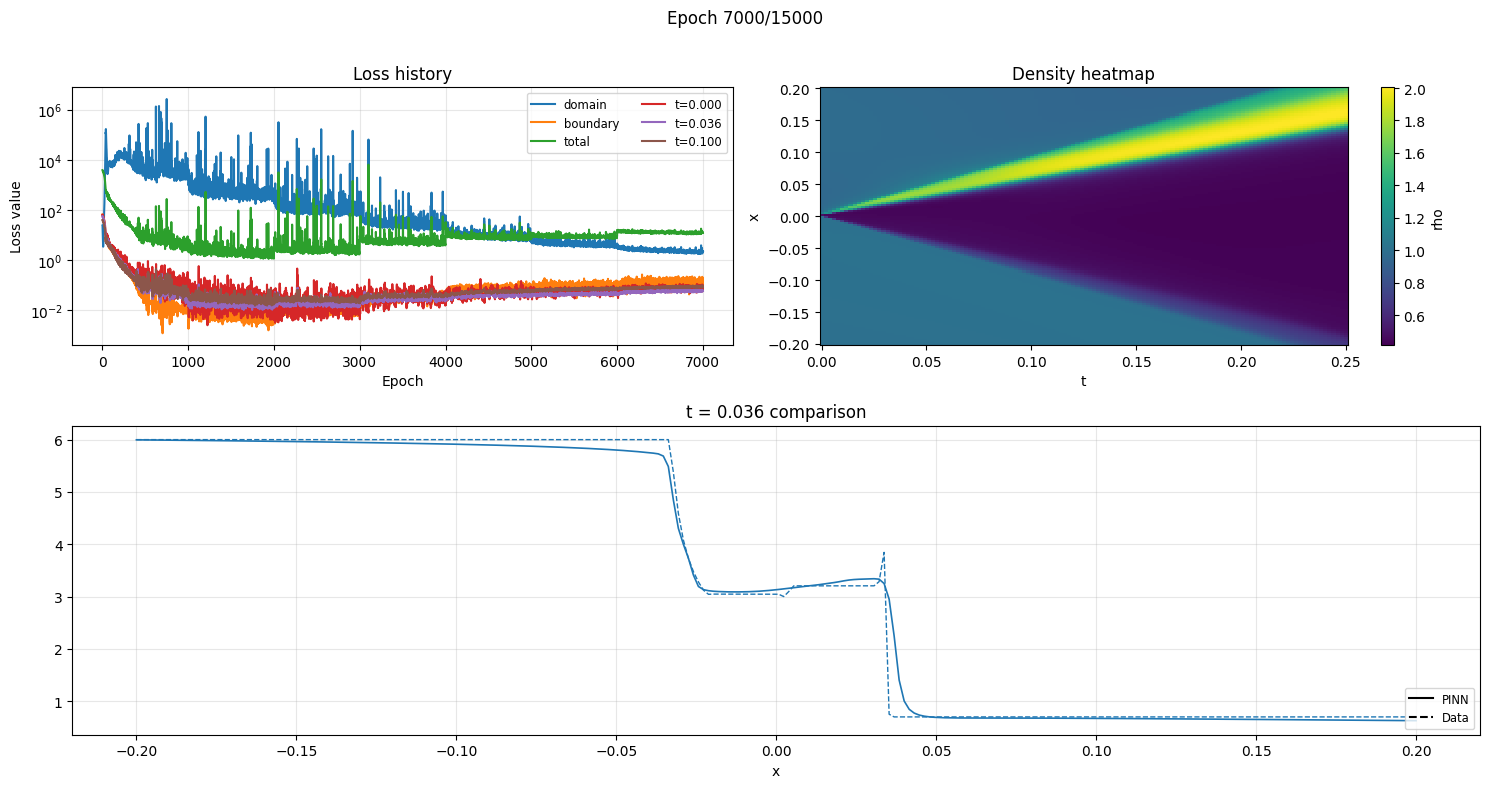

KeyboardInterrupt: 

In [14]:
for epoch in range(1, epochs + 1):



    model.train()
    optimizer.zero_grad()

    coords_domain = sample_domain(n_domain)
    preds_domain = model(coords_domain)
    residual_norm = jacobian_residual(preds_domain, coords_domain)
    domain_loss = F.mse_loss(residual_norm, torch.zeros_like(residual_norm))
    total_loss = lambda_domain * domain_loss

    x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    data_losses = {}
    for t in condition_times:
        t_tensor = torch.full_like(x_data, fill_value=t)
        coords_data = torch.cat([x_data, t_tensor], dim=1)
        preds_data = model(coords_data)
        targets_data = cond(t, x_data.squeeze(-1), device=DEVICE)
        data_loss = F.mse_loss(preds_data, targets_data)
        data_losses[f"t={t:.3f}"] = data_loss
        total_loss = total_loss + lambda_time[t] * data_loss

    x_boundary = prepare_boundary_points(n_boundary)
    t_half = torch.rand(n_boundary // 2, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0] - 0.02) + T_DOMAIN[0]
    t_boundary = torch.cat([t_half, t_half], dim=0)

    coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)

    preds_boundary = model(coords_boundary)
    targets_boundary = cond(0.0, x_boundary.squeeze(-1), device=DEVICE)
    boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
    total_loss = total_loss + lambda_bdy * boundary_loss

    total_loss.backward()
    if grad_clip is not None:
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()                
    if epoch % schedule_epoch == 0:
        n_domain *= 2
        if lambda_domain_idx < len(lambda_domain_sch):
            lambda_domain = lambda_domain_sch[lambda_domain_idx]
            lambda_domain_idx += 1
        lrg *= lrg_decay
        for group in optimizer.param_groups:
            group["lr"] = lrg


    loss_history["domain"].append(domain_loss.item())
    loss_history["boundary"].append(boundary_loss.item())
    loss_history["total"].append(total_loss.item())
    for t_key, loss_val in data_losses.items():
        loss_history[t_key].append(loss_val.item())

    if epoch % 50 == 0:
        clear_output(wait=True)
        current_lr = optimizer.param_groups[0]["lr"]
        print(f"Epoch {epoch:4d}/{epochs} | total_loss={total_loss.item():.4e} | domain={domain_loss.item():.4e} | boundary={boundary_loss.item():.4e} | lr={current_lr:.2e}")
        plot_training_progress(loss_history, model, epoch, epochs)




# Residual Network

In [ ]:
# --- free baseline training state ---
del loss_history
del optimizer
del param_groups
del coords_domain, x_data, coords_data, x_boundary, coords_boundary
torch.cuda.empty_cache()        # skip if you're on CPU-only
torch.mps.empty_cache()         # only if you trained on MPS

import gc
gc.collect()

# Reload the frozen baseline so only inference buffers remain
torch.save(model.state_dict(), "baseline_main.pt")
del model
gc.collect()

model = PINN(width=64, depth=24).to(DEVICE)
model.load_state_dict(torch.load("baseline_main.pt"))
model.eval()


In [13]:
model = PINN(width=64, depth=24).to(DEVICE)
model.load_state_dict(torch.load("baseline_main.pt", map_location=DEVICE))


<All keys matched successfully>

In [14]:
def build_residual_mixture_coords(
    model: PINN,
    grid_size: int,
    *,
    candidate_factor: int = 3,
    residual_power: float = 3.0,
    uniform_mix: float = 0.1,
    eps: float = 1e-12,
) -> torch.Tensor:

    n_keep = grid_size * grid_size
    n_candidates = candidate_factor * n_keep
    coords_candidates = sample_domain(n_candidates)

    with torch.enable_grad():
        preds = model(coords_candidates)
        residual = jacobian_residual(preds, coords_candidates)
        weights = residual.norm(dim=1).detach()

    if residual_power != 1.0:
        weights = weights.pow(residual_power)

    weights = weights.clamp(min=0)
    weighted = weights / (weights.sum() + eps)
    uniform = torch.full_like(weighted, 1.0 / n_candidates)

    probs = (1.0 - uniform_mix) * weighted + uniform_mix * uniform
    probs = probs / probs.sum()  # numerical guard

    idx = torch.multinomial(probs, n_keep, replacement=False)
    coords_residual = coords_candidates[idx].detach()


    return coords_residual

In [15]:
coords_residual = build_residual_mixture_coords(
    model,
    grid_size=128,          # final grid dimension
    candidate_factor=4,     # evaluate 8× as many points before sampling
    residual_power=3.0,     # bias toward larger residuals
    uniform_mix=0.1,        # keep 10% uniform mass so small residuals stay represented
)

In [16]:
def sample_res(n_res: int) -> torch.Tensor:
    indices = torch.randperm(coords_residual.shape[0])[:n_res]
    sample = coords_residual[indices]
    return indices, sample.requires_grad_(True)


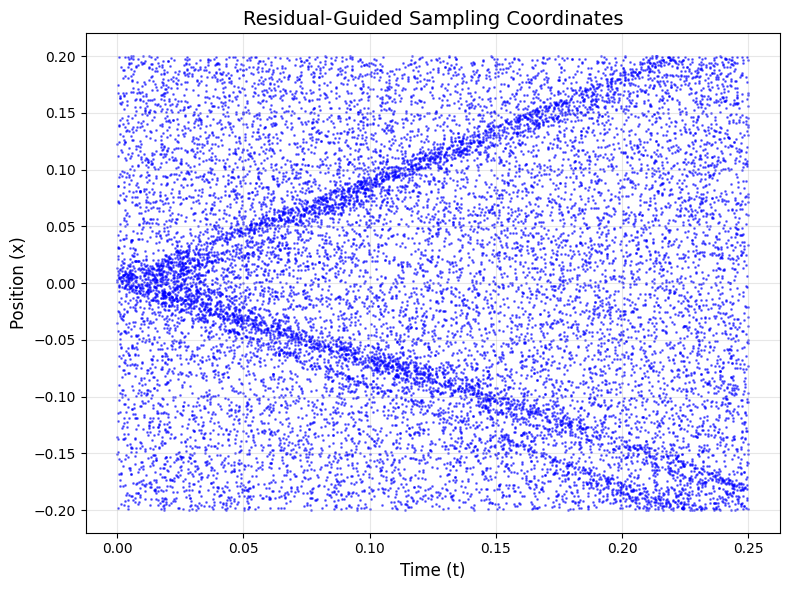

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

# Extract x and t coordinates
x_coords = coords_residual[:, 0].cpu().numpy()
t_coords = coords_residual[:, 1].cpu().numpy()

# Create scatter plot
scatter = ax.scatter(t_coords, x_coords, c='blue', alpha=0.5, s=1)

ax.set_xlabel('Time (t)', fontsize=12)
ax.set_ylabel('Position (x)', fontsize=12)
ax.set_title('Residual-Guided Sampling Coordinates', fontsize=14)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



## Data saving

In [18]:
def data_out(primitives: torch.Tensor, coords: torch.Tensor, B_x: float = 5.0) -> torch.Tensor:
    if not coords.requires_grad:
        raise ValueError("coords must require gradients for residual computation.")
    B_x=5.0
    B_x_tensor = torch.full((primitives.shape[0], 1), B_x, device=primitives.device, dtype=primitives.dtype)
    primitives_2d = torch.cat([primitives[:, :4], B_x_tensor, primitives[:, 4:]], dim=1)
    M = compute_M(primitives_2d)
    AX = compute_AX(primitives_2d)
    # Remove 4th row and 4th column (index 3) from M and AX
    mask1 = torch.tensor([0, 1, 2, 3, 5, 6, 7], device=M.device)
    #mask2 = torch.tensor([0, 1, 2, 4, 5, 6, 7], device=M.device)
    M = M[:, mask1, :][:, :, mask1]
    AX = AX[:, mask1, :][:, :, mask1]
    dP_dx = _partial_derivative(primitives, coords, dim=0).unsqueeze(-1)  # (batch, 7, 1)
    dP_dt = _partial_derivative(primitives, coords, dim=1).unsqueeze(-1)  # (batch, 7, 1)
    return M, AX, dP_dt , dP_dx

In [19]:
batch_size = coords_residual.shape[0]
chunk_size = 4096 #8192          # adjust for your GPU/MPS
chunks = []
start = 0

M_list, AX_list, S_list, dpdt_list, dpdx_list = [], [], [], [], []

while start < batch_size:
    end = min(start + chunk_size, batch_size)

    coords_chunk = coords_residual[start:end].detach().requires_grad_(True)
    prim_chunk = model(coords_chunk)

    M_chunk, AX_chunk, dpdt_chunk, dpdx_chunk = data_out(prim_chunk, coords_chunk, B_x=5.0)

    M_flat  = M_chunk.reshape(M_chunk.size(0), -1)
    AX_flat = AX_chunk.reshape(AX_chunk.size(0), -1)

    dM_dt  = _partial_derivative(M_flat,  coords_chunk, dim=1).reshape_as(M_chunk)
    dAX_dx = _partial_derivative(AX_flat, coords_chunk, dim=0).reshape_as(AX_chunk)

    S_chunk = dM_dt + dAX_dx

    M_list.append(M_chunk.detach())
    AX_list.append(AX_chunk.detach())
    S_list.append(S_chunk.detach())
    dpdt_list.append(dpdt_chunk.detach())
    dpdx_list.append(dpdx_chunk.detach())

    del coords_chunk, prim_chunk, M_chunk, AX_chunk, dM_dt, dAX_dx, S_chunk, dpdt_chunk, dpdx_chunk
    torch.mps.empty_cache()   # or torch.cuda.empty_cache()

    start = end

M_r  = torch.cat(M_list,  dim=0)
AX_r = torch.cat(AX_list, dim=0)
S_r  = torch.cat(S_list,  dim=0)
dpdt_r = torch.cat(dpdt_list, dim=0)
dpdx_r = torch.cat(dpdx_list, dim=0)

In [20]:
def lin_eq(output: torch.Tensor, ind: int, coords: torch.Tensor) -> torch.Tensor:
    
    dp_dt = _partial_derivative(output, coords, dim=1).unsqueeze(-1)  # (batch, 7, 1)
    dp_dx = _partial_derivative(output, coords, dim=0).unsqueeze(-1)  # (batch, 7, 1)
    p = output.unsqueeze(-1)  # (batch, 7, 1)

    return (M_r[ind] @ (dp_dt - dpdt_r[ind]) + AX_r[ind] @ (dp_dx - dpdx_r[ind]) + S_r[ind] @ p).squeeze(-1)  # (batch, 7)

## Instantiate Residual Network

In [55]:
model_residual = PINN(width=64, depth=24).to(DEVICE)

param_groups = []
lrg=1e-3

def add_group(param, role):
    param_groups.append({"params": [param], "role": role, "lr": lrg, "momentum": 0.9})

add_group(model_residual.layers[0].weight, "first")
add_group(model_residual.layers[0].bias, "bias")

for layer in model_residual.layers[1:]:
    add_group(layer.weight, "hidden")
    add_group(layer.bias, "bias")

add_group(model_residual.output_layer.weight, "last")
add_group(model_residual.output_layer.bias, "bias")

for name, p in model_residual.named_parameters():
    if "activation" in name and p.ndim == 0:
        add_group(p, "scalar")

optimizer = ScaledMuon(param_groups)

condition_times = [0.0, 0.036, 0.1]

loss_history = {"domain": [], "boundary": [], "total": []}
for t in condition_times:
    loss_history[f"t={t:.3f}"] = []

## Training Residual NET

In [56]:
lambda_domain_sch = [0.001, 0.01, 0.1, 0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
epochs = 15000
n_res = 1024
n_intermediate = 2048
n_boundary = 512
lambda_domain = 0.0001
lambda_bdy = 10.0
lambda_time = {0.0: 20.0, 0.036: 20.0, 0.1: 20.0}
grad_clip = 0.6
schedule_epoch = 1500
lrg = 0.001 #current_lrg = lrg
lrg_decay = 0.3
res_lambda_idx = 0

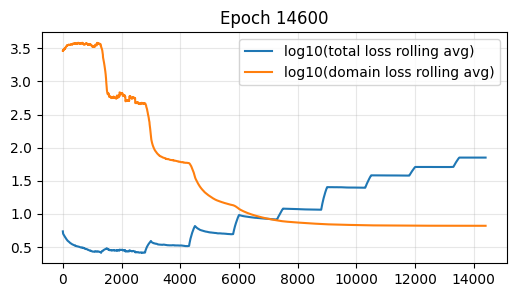

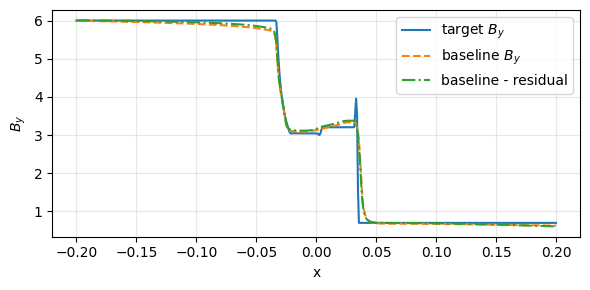

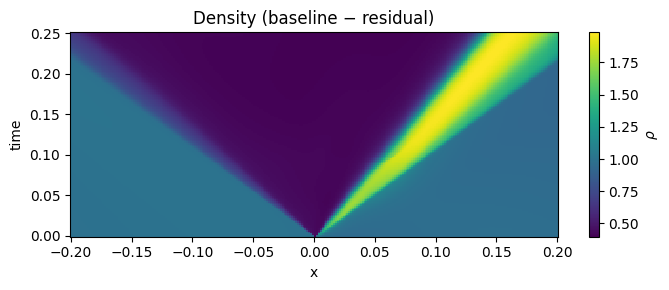

KeyboardInterrupt: 

In [57]:
res_loss_history = []
domain_loss_history = []
window_size = 200
for epoch in range(1, epochs + 1):
    model_residual.train()
    optimizer.zero_grad()

    idx_res, coords_domain = sample_res(n_res)
    preds_domain = model_residual(coords_domain)
    residual = lin_eq(preds_domain, idx_res, coords_domain)
    domain_loss = F.mse_loss(residual, torch.zeros_like(residual))
    res_loss = lambda_domain * domain_loss

    # intermediate loss
    x_data = torch.rand(n_intermediate, 1, device=DEVICE) * (X_DOMAIN[1] - X_DOMAIN[0]) + X_DOMAIN[0]
    data_losses = {}
    for t in condition_times:
        t_tensor = torch.full_like(x_data, fill_value=t)
        coords_data = torch.cat([x_data, t_tensor], dim=1)
        preds_data = model_residual(coords_data)
        targets_data = -cond(t, x_data.squeeze(-1), device=DEVICE) + model(coords_data).detach()
        data_loss = F.mse_loss(preds_data, targets_data)
        data_losses[f"t={t:.3f}"] = data_loss
        res_loss = res_loss + lambda_time[t] * data_loss

    # boundary loss
    x_boundary = prepare_boundary_points(n_boundary)
    t_half = torch.rand(n_boundary // 2, 1, device=DEVICE) * (T_DOMAIN[1] - T_DOMAIN[0] - 0.02) + T_DOMAIN[0]
    t_boundary = torch.cat([t_half, t_half], dim=0)
    coords_boundary = torch.cat([x_boundary, t_boundary], dim=1)

    preds_boundary = model_residual(coords_boundary)
    targets_boundary = -cond(0.0, x_boundary.squeeze(-1), device=DEVICE) + model(coords_boundary).detach()
    boundary_loss = F.mse_loss(preds_boundary, targets_boundary)
    res_loss = res_loss + lambda_bdy * boundary_loss

    # optimizer step
    res_loss.backward()
    torch.nn.utils.clip_grad_norm_(model_residual.parameters(), max_norm=0.5)
    optimizer.step()

    # schedule updates (same cadence as main loop)
    if epoch % schedule_epoch == 0:
        n_res *= 2
        if res_lambda_idx < len(lambda_domain_sch):
            lambda_domain = lambda_domain_sch[res_lambda_idx]
            res_lambda_idx += 1
        lrg *= lrg_decay
        for group in optimizer.param_groups:
            group["lr"] = lrg

    res_loss_history.append(res_loss.item())
    domain_loss_history.append(domain_loss.item())

    if epoch % 50 == 0 or epoch == 1:
        clear_output(wait=True)
        if len(res_loss_history) >= window_size:
            res_loss_rolling = np.convolve(res_loss_history, np.ones(window_size)/window_size, mode='valid')
            domain_loss_rolling = np.convolve(domain_loss_history, np.ones(window_size)/window_size, mode='valid')
        else:
            res_loss_rolling = res_loss_history
            domain_loss_rolling = domain_loss_history

        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(np.log10(res_loss_rolling), label='log10(total loss rolling avg)')
        ax.plot(np.log10(domain_loss_rolling), label='log10(domain loss rolling avg)')
        ax.set_title(f'Epoch {epoch}')
        ax.grid(alpha=0.3)
        ax.legend()

        # B_y snapshot
        t_vis = 0.036
        x_vis = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 512, device=DEVICE).unsqueeze(-1)
        coords_vis = torch.cat([x_vis, torch.full_like(x_vis, t_vis)], dim=1)
        with torch.no_grad():
            baseline = model(coords_vis)
            residual = model_residual(coords_vis)
            corrected = baseline - residual
            target = cond(t_vis, x_vis.squeeze(-1), device=DEVICE)

        x_cpu = x_vis.squeeze(-1).cpu().numpy()
        fig, ax = plt.subplots(figsize=(6, 3))
        ax.plot(x_cpu, target[:, 4].cpu(), label='target $B_y$')
        ax.plot(x_cpu, baseline[:, 4].cpu(), '--', label='baseline $B_y$')
        ax.plot(x_cpu, corrected[:, 4].cpu(), '-.', label='baseline - residual')
        ax.set_xlabel('x'); ax.set_ylabel('$B_y$'); ax.grid(alpha=0.3); ax.legend()
        plt.tight_layout()

        # density heatmap
        times = torch.linspace(0.0, 0.25, 120, device=DEVICE)
        x_heat = torch.linspace(X_DOMAIN[0], X_DOMAIN[1], 256, device=DEVICE)
        rho_map = torch.empty(times.size(0), x_heat.size(0), device=DEVICE)
        with torch.no_grad():
            for i, t in enumerate(times):
                coords = torch.stack((x_heat, torch.full_like(x_heat, t)), dim=1)
                rho_map[i] = (model(coords) - model_residual(coords))[:, 0]
        fig, ax = plt.subplots(figsize=(7, 3))
        pcm = ax.pcolormesh(x_heat.cpu(), times.cpu(), rho_map.cpu(), shading='auto', cmap='viridis')
        fig.colorbar(pcm, ax=ax, label=r'$\rho$')
        ax.set_xlabel('x'); ax.set_ylabel('time'); ax.set_title('Density (baseline − residual)')
        plt.tight_layout()
        plt.show()


In [58]:
def corr(x):
    return model(x) - model_residual(x)

In [89]:
coords_domain = sample_domain(100)
pred_test1 = model(coords_domain)
pred_test2 = corr(coords_domain)


residual_test1 = jacobian_residual(pred_test1, coords_domain)
residual_test2 = jacobian_residual(pred_test2, coords_domain)
print(F.mse_loss(residual_test1, torch.zeros_like(residual_test1)))
print(F.mse_loss(residual_test2, torch.zeros_like(residual_test2)))

tensor(6.2449, device='mps:0', grad_fn=<MseLossBackward0>)
tensor(133.3298, device='mps:0', grad_fn=<MseLossBackward0>)


## Clean a little

In [60]:
_to_clear = ["M_r", "AX_r", "S_r", "dpdt_r", "dpdx_r"]
cleared = []
for _name in _to_clear:
    if _name in globals():
        _obj = globals().pop(_name)
        del _obj
        cleared.append(_name)

if hasattr(torch, "mps"):
    try:
        torch.mps.empty_cache()
    except AttributeError:
        pass
if torch.cuda.is_available():
    torch.cuda.empty_cache()


if cleared:
    print(f"Cleared tensors: {cleared}")
else:
    print("No first-iteration tensors to clear.")

import gc



# Drop any leftover large objects you don’t need
for name in ["M_list_iter", "AX_list_iter", "S_list_iter",
             "dpdt_list_iter", "dpdx_list_iter",
             "M_r_iter", "AX_r_iter", "S_r_iter",
             "dpdt_r_iter", "dpdx_r_iter"]:
    if name in globals():
        del globals()[name]

gc.collect()

if hasattr(torch, "mps"):
    try:
        torch.mps.empty_cache()
    except AttributeError:
        pass

if torch.cuda.is_available():
    torch.cuda.empty_cache()

Cleared tensors: ['M_r', 'AX_r', 'S_r', 'dpdt_r', 'dpdx_r']
